## Control vs. Everything UPDRS, Age, Sex

From request [Run control vs everything with UPDRS plus](https://trello.com/c/AHbuKTX4)

Run the following models: 

Control vs. PD
Control vs. MSA
Control vs. PSP 

## Imports and Function Definitions

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [25]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')[['GroupID','Age','Sex','UPDRS']]
_random_seed = 55

## 7. Control vs. PD

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished


Best parameters set found on development set:

{'classifier__C': 0.54555947811685146}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        63
        1.0       0.95      0.95      0.95        95

avg / total       0.94      0.94      0.94       158


Confusion matrix, without normalization
[[58  5]
 [ 5 90]]

recall	0.947368421053
precision	0.947368421053
auc	0.934001670844
specificity	0.920634920635
npv	0.920634920635
accuracy	0.936708860759
weighted_sensitivity	0.947368421053
weighted_ppv	0.922701383238
weighted_specificity	0.920634920635
weighted_npv	0.945922746781
weighted_accuracy	0.934001670844


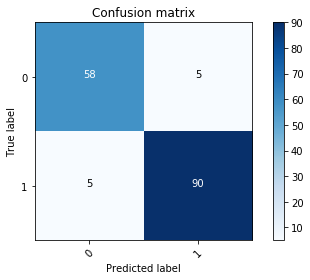

In [26]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [27]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00759944915771	0.000799689218286
score_time	0.0071310043335	0.000434659043414
test_recall	0.94718875502	0.0368494413051
train_recall	0.945316400738	0.00855616739599
test_precision	0.985357142857	0.0179426524101
train_precision	0.983750676619	0.00457737081783
test_auc	0.959640889138	0.0253796899425
train_auc	0.957541921299	0.00682499420008
test_specificity	0.972093023256	0.0341789266435
train_specificity	0.96976744186	0.00854473166087
test_npv	0.908484639012	0.0588212688844
train_npv	0.90180558603	0.0142608775918
test_accuracy	0.955680539933	0.0271498289162
train_accuracy	0.953647650479	0.00702517876969
test_weighted_sensitivity	0.94718875502	0.0368494413051
train_weighted_sensitivity	0.945316400738	0.00855616739599
test_weighted_ppv	0.972510565449	0.0336913764778
train_weighted_ppv	0.969062248188	0.00862127744406
test_weighted_specificity	0.972093023256	0.0341789266435
train_weighted_specificity	0.96976744186	0.00854473166087
test_weighted_npv	0.949583579475	0.0335165592531


In [28]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.423054745945
Sex	-0.105277768576
UPDRS	3.17288985309


             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        63
        1.0       0.95      0.95      0.95        95

avg / total       0.94      0.94      0.94       158



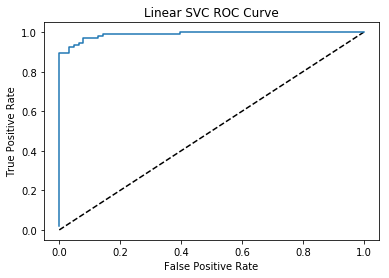

0.0 0.0210526315789
0.0 0.263157894737
0.0 0.284210526316
0.0 0.473684210526
0.0 0.494736842105
0.0 0.610526315789
0.0 0.631578947368
0.0 0.894736842105
0.031746031746 0.894736842105
0.031746031746 0.926315789474
0.047619047619 0.926315789474
0.047619047619 0.936842105263
0.0634920634921 0.936842105263
0.0634920634921 0.947368421053
0.0793650793651 0.947368421053
0.0793650793651 0.968421052632
0.0952380952381 0.968421052632
0.126984126984 0.968421052632
0.126984126984 0.978947368421
0.142857142857 0.978947368421
0.142857142857 0.989473684211
0.396825396825 0.989473684211
0.396825396825 1.0
0.619047619048 1.0
0.68253968254 1.0
1.0 1.0


In [29]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 8. Control vs MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


Best parameters set found on development set:

{'classifier__C': 0.061584821106602607}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98        62
        1.0       0.85      1.00      0.92        11

avg / total       0.98      0.97      0.97        73


Confusion matrix, without normalization
[[60  2]
 [ 0 11]]

recall	1.0
precision	0.846153846154
auc	0.983870967742
specificity	0.967741935484
npv	1.0
accuracy	0.972602739726
weighted_sensitivity	1.0
weighted_ppv	0.96875
weighted_specificity	0.967741935484
weighted_npv	1.0
weighted_accuracy	0.983870967742


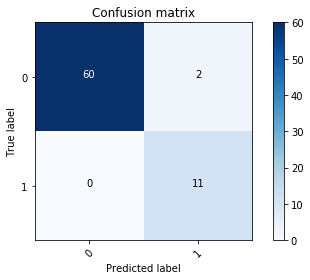

In [30]:
# Get the data
data2 = group_classes(_data, {0:0, 2:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [31]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00300669670105	0.000851816979948
score_time	0.0060215473175	0.00062128517414
test_recall	0.986666666667	0.0266666666667
train_recall	0.986323787259	0.00683935508887
test_precision	0.975	0.05
train_precision	0.973107344633	0.013448701305
test_auc	0.988682170543	0.0142230634929
train_auc	0.988530894839	0.00364638431961
test_specificity	0.990697674419	0.0186046511628
train_specificity	0.99073800242	0.00463107195359
test_npv	0.995454545455	0.00909090909091
train_npv	0.995355402674	0.0023225291313
test_accuracy	0.989534180278	0.0140053296558
train_accuracy	0.989614024157	0.00346999134389
test_weighted_sensitivity	0.986666666667	0.0266666666667
train_weighted_sensitivity	0.986323787259	0.00683935508887
test_weighted_ppv	0.991111111111	0.0177777777778
train_weighted_ppv	0.990725562645	0.00463806403919
test_weighted_specificity	0.990697674419	0.0186046511628
train_weighted_specificity	0.99073800242	0.00463107195359
test_weighted_npv	0.9875	0.025
train_weighted_npv	0.986437179171	0.0

In [32]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.0940992264388
Sex	-0.0755739365963
UPDRS	1.48588389488


             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98        62
        1.0       0.85      1.00      0.92        11

avg / total       0.98      0.97      0.97        73



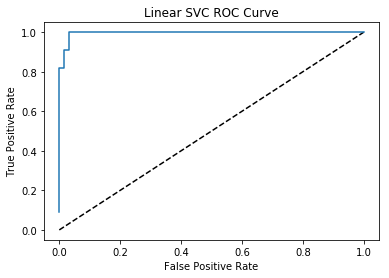

0.0 0.0909090909091
0.0 0.818181818182
0.0161290322581 0.818181818182
0.0161290322581 0.909090909091
0.0322580645161 0.909090909091
0.0322580645161 1.0
0.596774193548 1.0
0.629032258065 1.0
0.790322580645 1.0
0.822580645161 1.0
0.887096774194 1.0
0.91935483871 1.0
0.967741935484 1.0
1.0 1.0


In [33]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 9. Control vs PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished


Best parameters set found on development set:

{'classifier__C': 1.1288378916846884}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.98      0.97      0.97        59
        1.0       0.92      0.96      0.94        23

avg / total       0.96      0.96      0.96        82


Confusion matrix, without normalization
[[57  2]
 [ 1 22]]

recall	0.95652173913
precision	0.916666666667
auc	0.961311717023
specificity	0.966101694915
npv	0.98275862069
accuracy	0.963414634146
weighted_sensitivity	0.95652173913
weighted_ppv	0.965773809524
weighted_specificity	0.966101694915
weighted_npv	0.956934306569
weighted_accuracy	0.961311717023


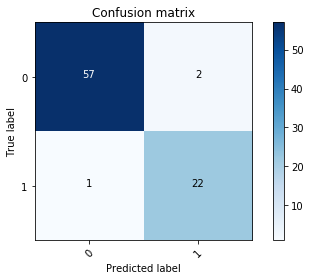

In [34]:
# Get the data
data3 = group_classes(_data, {0:0, 3:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [35]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00419964790344	0.00039061382979
score_time	0.00670528411865	0.000749223668486
test_recall	0.94329004329	0.0192823008237
train_recall	0.943389355742	0.00478360519291
test_precision	0.93577451534	0.0331358754516
train_precision	0.934658463225	0.00887609118143
test_auc	0.955683076613	0.0115466135944
train_auc	0.955714158391	0.00288618792878
test_specificity	0.968076109937	0.0181301197248
train_specificity	0.968038961039	0.00455257327533
test_npv	0.972607134468	0.00853519056038
train_npv	0.972485365774	0.00219996171662
test_accuracy	0.959997086247	0.0123091504774
train_accuracy	0.959999749655	0.0030788314071
test_weighted_sensitivity	0.94329004329	0.0192823008237
train_weighted_sensitivity	0.943389355742	0.00478360519291
test_weighted_ppv	0.967657611418	0.0172387179706
train_weighted_ppv	0.967256746973	0.00451949236742
test_weighted_specificity	0.968076109937	0.0181301197248
train_weighted_specificity	0.968038961039	0.00455257327533
test_weighted_npv	0.945037715721	0.01696989436

In [36]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.0824967933304
Sex	-0.0840756712987
UPDRS	2.97378717349


             precision    recall  f1-score   support

        0.0       0.98      0.97      0.97        59
        1.0       0.92      0.96      0.94        23

avg / total       0.96      0.96      0.96        82



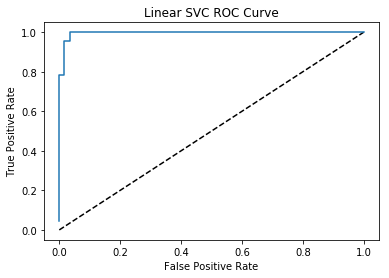

0.0 0.0434782608696
0.0 0.782608695652
0.0169491525424 0.782608695652
0.0169491525424 0.95652173913
0.0338983050847 0.95652173913
0.0338983050847 1.0
0.440677966102 1.0
0.474576271186 1.0
0.627118644068 1.0
0.694915254237 1.0
0.71186440678 1.0
0.745762711864 1.0
0.881355932203 1.0
0.949152542373 1.0
1.0 1.0


In [37]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)